# Test problem 2: Flow past a cylinder (DFG 2D-3 benchmark)
Author: Jørgen S. Dokken

In this section, we will turn our attention to a slightly more challenging problem: flow past a cylinder. The geometry and parameters are taken from the [DFG 2D-3 benchmark](http://www.featflow.de/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark3_re100.html) in FeatFlow.

To be able to solve this problem efficiently and ensure numerical stability, we will subsitute our first order backward difference scheme with a second order backward difference approximation, and use an explicit Adams-Bashforth approximation of the non-linear term.

```{admonition} Computationally demanding demo
This demo is computationally demanding, with a run-time up to 25 minutes, as it is using parameters from the DFG 2D-3 benchmark, which consists of 12800 time steps. It is adviced to download this demo and  not run it in a browser. Please also see the last part of the tutorial on how to use `mpirun` to speedup the run-time of the program.
```

The computational geometry we would like to use is
![Fluid channel with a circular obstacle](turek.png)

The kinematic velocity is given by $\nu=0.001=\frac{\mu}{\rho}$ and the inflow velocity profile is specified as

$$
    u(x,y,t) = \left( \frac{4Uy(0.41-y)}{0.41^2}, 0 \right)
$$
$$
    U=U(t) = 1.5\sin(\pi t/8)
$$

which has a maximum magnitude of $1.5$ at $y=0.41/2$. We do not use any scaling for this problem since all exact parameters are known. 
## Mesh generation
As in the [Deflection of a membrane](./../chapter1/membrane_code.ipynb) we use GMSH to generate the mesh. We fist create the rectangle and obstacle.

In [1]:
from mpi4py import MPI
import gmsh
gmsh.initialize()

L = 2.2
H = 0.41
c_x = c_y =0.2
r = 0.05
gdim = 2
rank = MPI.COMM_WORLD.rank
if rank == 0:
    rectangle = gmsh.model.occ.addRectangle(0,0,0, L, H, tag=1)
    obstacle = gmsh.model.occ.addDisk(c_x, c_y, 0, r, r)

The next step is to subtract the obstacle from the channel, such that we do not mesh the interior of the circle.

In [2]:
if rank == 0:
    fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
    gmsh.model.occ.synchronize()

To get GMSH to mesh the fluid, we add a physical volume marker

In [3]:
fluid_marker = 1
if rank == 0:
    volumes = gmsh.model.getEntities(dim=gdim)
    gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
    gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")

To tag the different surfaces of the mesh, we tag the inflow (left hand side) with marker 2, the outflow (right hand side) with marker 3 and the fluid walls with 4 and obstacle with 5. We will do this by compute the center of mass for each geometrical entitiy.

In [4]:
import numpy as np
inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
inflow, outflow, walls, obstacle = [], [], [], []
if rank == 0:
    boundaries = gmsh.model.getBoundary(volumes)
    for boundary in boundaries:
        center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
        if np.allclose(center_of_mass, [0, H/2, 0]):
            inflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L, H/2, 0]):
            outflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L/2, H, 0]) or np.allclose(center_of_mass, [L/2, 0, 0]):
            walls.append(boundary[1])
        else:
            obstacle.append(boundary[1])
    gmsh.model.addPhysicalGroup(1, walls, wall_marker)
    gmsh.model.setPhysicalName(1, wall_marker, "Walls")
    gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
    gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
    gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
    gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
    gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
    gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

In our previous meshes, we have used uniform mesh sizes. In this example, we will have variable mesh sizes to resolve the flow solution in  the area of interest; close to the circular obstacle. To do this, we use GMSH Fields.

In [5]:
# Create distance field from obstacle.
# Add threshold of mesh sizes based on the distance field
# LcMax -                  /--------
#                      /
# LcMin -o---------/
#        |         |       |
#       Point    DistMin DistMax
res_min = r / 3.7
res_max = 1.5 * r
if rank == 0:
    gmsh.model.mesh.field.add("Distance", 1)
    gmsh.model.mesh.field.setNumbers(1, "EdgesList", obstacle)
    gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(2, "IField", 1)
    gmsh.model.mesh.field.setNumber(2, "LcMin", res_min)
    gmsh.model.mesh.field.setNumber(2, "LcMax", res_max)
    gmsh.model.mesh.field.setNumber(2, "DistMin", 4*r)
    gmsh.model.mesh.field.setNumber(2, "DistMax", 8*r)

    # We take the minimum of the two fields as the mesh size
    gmsh.model.mesh.field.add("Min", 5)
    gmsh.model.mesh.field.setNumbers(5, "FieldsList", [2])
    gmsh.model.mesh.field.setAsBackgroundMesh(5)

## Generating the mesh
We are now ready to generate the mesh. However, we have to decide if our mesh should consist of triangles or quadrilaterals. In this demo, to match the DFG 2D-3 benchmark, we use quadrilateral elements. This is done by recombining the mesh, setting two gmsh options. 

In [6]:
if rank == 0:
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 8)
    gmsh.option.setNumber("Mesh.RecombineAll", 2)
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.optimize("Netgen")

## Loading mesh and boundary markers
As we have generated the mesh, we now need to load the mesh and corresponding facet markers into DOLFINx.
To load the mesh, we follow the same structure as in  [Deflection of a membrane](./../chapter1/membrane_code.ipynb), with slight modifications to include the facet markers. To learn more about the specifics of the function below, see [A GMSH tutorial for DOLFINx](http://jsdokken.com/converted_files/tutorial_gmsh.html).

In [7]:
from dolfinx.io import extract_gmsh_geometry, extract_gmsh_topology_and_markers, ufl_mesh_from_gmsh
from dolfinx.cpp.io import perm_gmsh, extract_local_entities
from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.cpp.graph import AdjacencyList_int32
from dolfinx.mesh import create_meshtags, create_mesh
if MPI.COMM_WORLD.rank == 0:
    # Get mesh geometry
    x = extract_gmsh_geometry(gmsh.model)

    # Get mesh topology for each element
    topologies = extract_gmsh_topology_and_markers(gmsh.model)
    # Get information about each cell type from the msh files
    num_cell_types = len(topologies.keys())
    cell_information = {}
    cell_dimensions = np.zeros(num_cell_types, dtype=np.int32)
    for i, element in enumerate(topologies.keys()):
        properties = gmsh.model.mesh.getElementProperties(element)
        name, dim, order, num_nodes, local_coords, _ = properties
        cell_information[i] = {"id": element, "dim": dim, "num_nodes": num_nodes}
        cell_dimensions[i] = dim

    # Sort elements by ascending dimension
    perm_sort = np.argsort(cell_dimensions)

    # Broadcast cell type data and geometric dimension
    cell_id = cell_information[perm_sort[-1]]["id"]
    tdim = cell_information[perm_sort[-1]]["dim"]
    num_nodes = cell_information[perm_sort[-1]]["num_nodes"]
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([cell_id, num_nodes], root=0)
    if tdim - 1 in cell_dimensions:
        num_facet_nodes = MPI.COMM_WORLD.bcast( cell_information[perm_sort[-2]]["num_nodes"], root=0)
        gmsh_facet_id = cell_information[perm_sort[-2]]["id"]
        marked_facets = np.asarray(topologies[gmsh_facet_id]["topology"], dtype=np.int64)
        facet_values = np.asarray(topologies[gmsh_facet_id]["cell_data"], dtype=np.int32)

    cells = np.asarray(topologies[cell_id]["topology"], dtype=np.int64)
    cell_values = np.asarray(topologies[cell_id]["cell_data"], dtype=np.int32)

else:
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([None, None], root=0)
    cells, x = np.empty([0, num_nodes], np.int64), np.empty([0, gdim])
    cell_values = np.empty((0,), dtype=np.int32)
    num_facet_nodes = MPI.COMM_WORLD.bcast(None, root=0)
    marked_facets = np.empty((0, num_facet_nodes), dtype=np.int64)
    facet_values = np.empty((0,), dtype=np.int32)

# Create distributed mesh
ufl_domain = ufl_mesh_from_gmsh(cell_id, gdim)
gmsh_cell_perm = perm_gmsh(to_type(str(ufl_domain.ufl_cell())), num_nodes)
cells = cells[:, gmsh_cell_perm]
mesh = create_mesh(MPI.COMM_WORLD, cells, x[:, :gdim], ufl_domain)
tdim = mesh.topology.dim
fdim = tdim - 1
# Permute facets from MSH to DOLFINx ordering
facet_type = cell_entity_type(to_type(str(ufl_domain.ufl_cell())), fdim)
gmsh_facet_perm = perm_gmsh(facet_type, num_facet_nodes)
marked_facets = np.asarray(marked_facets[:, gmsh_facet_perm], dtype=np.int64)

local_entities, local_values = extract_local_entities(mesh, fdim, marked_facets, facet_values)
mesh.topology.create_connectivity(fdim, tdim)
adj = AdjacencyList_int32(local_entities)
# Create DOLFINx MeshTags
ft = create_meshtags(mesh, fdim, adj, np.int32(local_values))
ft.name = "Facet tags"

## Physical and discretization parameters
Following the DGF-2 benchmark, we define our problem specific parameters

In [8]:
import dolfinx
t = 0
T = 1 #8                    # Final time
dt = 1/1600                 # Time step size
num_steps = int(T/dt)
k = dolfinx.Constant(mesh, dt)        
mu = dolfinx.Constant(mesh, 0.001)  # Dynamic viscosity
rho = dolfinx.Constant(mesh, 1)     # Density

```{admonition} Reduced end-time of problem
In the current demo, we have reduced the run time to one second to make it easier to illustrate the concepts of the benchmark. By increasing the end-time `T` to 8, the runtime in a notebook is approximately 25 minutes. If you convert the notebook to a python file and use `mpirun`, you can reduce the runtime of the problem.
```

## Boundary conditions
As we have created the mesh and relevant mesh tags, we can now specify the function spaces `V` and `Q` along with the boundary conditions. As the `ft` contains markers for facets, we use this class to find the facets for the inlet and walls.

In [9]:
import ufl
v_cg2 = ufl.VectorElement("CG", mesh.ufl_cell(), 2)
s_cg1 = ufl.FiniteElement("CG", mesh.ufl_cell(), 1)
V = dolfinx.FunctionSpace(mesh, v_cg2)
Q = dolfinx.FunctionSpace(mesh, s_cg1)

from petsc4py import PETSc
fdim = mesh.topology.dim - 1

# Define boundary conditions
class InletVelocity():
    def __init__(self, t):
        self.t = t

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]),dtype=PETSc.ScalarType)
        values[0] = 4 * 1.5 * np.sin(self.t * np.pi/8) * x[1] * (0.41 - x[1])/(0.41**2)
        return values

# Inlet
u_inlet = dolfinx.Function(V)
inlet_velocity = InletVelocity(t)
u_inlet.interpolate(inlet_velocity)
u_inlet.x.scatter_forward()
inlet_facets = ft.indices[ft.values == inlet_marker]

bcu_inflow = dolfinx.DirichletBC(u_inlet, dolfinx.fem.locate_dofs_topological(V, fdim, inlet_facets))
# Walls
u_nonslip = dolfinx.Function(V)
with u_nonslip.vector.localForm() as loc:
    loc.set(0)
wall_facets = ft.indices[ft.values == wall_marker]
bcu_walls = dolfinx.DirichletBC(u_nonslip, dolfinx.fem.locate_dofs_topological(V, fdim, wall_facets))
# Obstacle
obstacle_facets = ft.indices[ft.values == obstacle_marker]
bcu_obstacle = dolfinx.DirichletBC(u_nonslip, dolfinx.fem.locate_dofs_topological(V, fdim, obstacle_facets))
bcu = [bcu_inflow, bcu_obstacle, bcu_walls]
# Outlet
p_outlet = dolfinx.Function(Q)
with p_outlet.vector.localForm() as loc:
    loc.set(0)
outlet_facets = ft.indices[ft.values == outlet_marker]
bcp_outlet = dolfinx.DirichletBC(p_outlet, dolfinx.fem.locate_dofs_topological(Q, fdim, outlet_facets))
bcp = [bcp_outlet]

## Variational form
As opposed to [Pouseille flow](./ns_code1.ipynb), we will use a Crank-Nicolson discretization, and an explicit Adams-Bashforth approximation.
The first step can be written as

$$
\rho\left(\frac{u^*- u^n}{\delta t} + \frac{3}{2} u^n \cdot \nabla u^n - \frac{1}{2} u^{n-1} \cdot \nabla u^{n-1}\right) - \frac{1}{2}\mu \Delta( u^*+ u^n )+ \nabla p^{n-1/2} = f^{n+\frac{1}{2}} \qquad \text{ in } \Omega
$$

$$
u^*=g(\cdot, t^{n+1}) \qquad \text{ on } \partial \Omega_{D}
$$

$$
\frac{1}{2}\nu \nabla (u^*+u^n) \cdot n = p^{n-\frac{1}{2}} \qquad \text{ on } \partial \Omega_{N}
$$
where we have used the two previous time steps in the temporal derivative for the velocity, and compute the pressure staggered in time, at the time between the previous and current solution. The second step becomes
$$
-\nabla \phi = -\frac{1}{\delta t} \nabla \cdot u^* \qquad\text{in } \Omega,
$$

$$
\nabla \phi \cdot n = 0 \qquad \text{on } \partial \Omega_D,\\
$$

$$
\phi = 0 \qquad\text{on } \partial\Omega_N
$$

where $p^{n+\frac{1}{2}}=p^{n-\frac{1}{2}} + \phi$.
Finally, the third step is

$$
u^{n+1} = u^{*}-\delta t \phi. 
$$

We start by defining all the variables used in the variational formulations.

In [10]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
u_ = dolfinx.Function(V)
u_.name = "u"
u_s = dolfinx.Function(V)
u_n = dolfinx.Function(V)
u_n1 = dolfinx.Function(V)
p = ufl.TrialFunction(Q)
q = ufl.TestFunction(Q)
p_ = dolfinx.Function(Q)
p_.name = "p"
phi = dolfinx.Function(Q)

Next, we define the variational formulation for the first step, where we have integrated the diffusion term, as well as the pressure term by parts. As we have used an explicit approximation of the non-linear term we only have to assemble the matrix once, but we have to save the two previous solutions.

In [11]:
from ufl import Identity, div, dot, ds, dx, inner, lhs, grad, nabla_grad, rhs, sym
f = dolfinx.Constant(mesh, (0,0))
F1 = rho / k * dot(u - u_n, v) * dx 
F1 += inner(1.5 * dot(u_n, nabla_grad(u_n)) - 0.5 * dot(u_n1, nabla_grad(u_n1)), v) * dx
F1 += 0.5 * mu * inner(grad(u+u_n), grad(v))*dx - dot(p_, div(v))*dx
F1 += dot(f, v) * dx
a1 = lhs(F1)
L1 = rhs(F1)
A1 = dolfinx.fem.assemble_matrix(a1, bcs=bcu)
A1.assemble()
b1 = dolfinx.fem.create_vector(L1)

Next we define the second step

In [12]:
a2 = dot(grad(p), grad(q))*dx
L2 = -1/k * dot(div(u_s), q) * dx
A2 = dolfinx.fem.assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = dolfinx.fem.create_vector(L2)

We finally create the last step

In [13]:
a3 = dot(u, v)*dx
L3 = dot(u_s, v)*dx - k * dot(nabla_grad(phi), v)*dx
A3 = dolfinx.fem.assemble_matrix(a3)
A3.assemble()
b3 = dolfinx.fem.create_vector(L3)

As in the previous tutorials, we use PETSc as a linear algebra backend.

In [14]:
# Solver for step 1
solver1 = PETSc.KSP().create(mesh.mpi_comm())
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.JACOBI)

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.mpi_comm())
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.MINRES)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.mpi_comm())
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

## Verification of the implementation compute known physical quantities
As a further verification of our implementation, we compute the drag and lift coefficients over the obstacle, defined as

$$
    C_{\text{D}}(u,p,t,\partial\Omega_S) = \frac{2}{\rho L U_{mean}^2}\int_{\partial\Omega_S}\rho \nu n \cdot \nabla u_{t_S}(t)n_y -p(t)n_x~\mathrm{d} s,
$$    
$$ 
    C_{\text{L}}(u,p,t,\partial\Omega_S) = -\frac{2}{\rho L U_{mean}^2}\int_{\partial\Omega_S}\rho \nu n \cdot \nabla u_{t_S}(t)n_x + p(t)n_y~\mathrm{d} s,
$$

where $u_{t_S}$ is the tangential velocity component at the interface of the obstacle $\partial\Omega_S$, defined as $u_{t_S}=u\cdot (n_y,-n_x)$, $U_{mean}=1$ the average inflow velocity, and $L$ the length of the channel. We use `UFL` to create the relevant integrals, and assemble them at each time step.

In [15]:
n = -ufl.FacetNormal(mesh) # Normal pointing out of obstacle
dObs = ufl.Measure("ds", domain=mesh, subdomain_data=ft, subdomain_id=obstacle_marker)
u_t = inner(ufl.as_vector((n[1], -n[0])), u_)
drag = 2 / 0.1 * (mu / rho * inner(ufl.grad(u_t), n) * n[1] - p_ * n[0]) * dObs
lift = -2 / 0.1 * (mu / rho * inner(ufl.grad(u_t), n) * n[0] + p_ * n[1]) * dObs
if rank == 0:
    C_D = np.zeros(num_steps, dtype=PETSc.ScalarType)
    C_L = np.zeros(num_steps, dtype=PETSc.ScalarType)
    t_u = np.zeros(num_steps, dtype=np.float64)
    t_p = np.zeros(num_steps, dtype=np.float64)

We will also evaluate the pressure at two points, on in front of the obstacle, $(0.15, 0.2)$, and one behind the obstacle, $(0.25, 0.2)$. To do this, we have to find which cell is containing each of the points, so that we can create a linear combination of the local basis functions and coefficients.

In [16]:
import dolfinx.geometry
tree = dolfinx.geometry.BoundingBoxTree(mesh, mesh.geometry.dim)
point_front = [0.15,0.2, 0]
# Use the bounding box tree of the cells to create a set of candidates colliding with the point.
cell_candidates_front = dolfinx.geometry.compute_collisions_point(tree, point_front)
# Select one cell that is actually colliding with the point
cell_front = dolfinx.cpp.geometry.select_colliding_cells(mesh, cell_candidates_front, point_front, 1)
point_back = [0.25,0.2, 0]
cell_candidates_back = dolfinx.geometry.compute_collisions_point(tree, point_back)
cell_back = dolfinx.cpp.geometry.select_colliding_cells(mesh, cell_candidates_back, point_back, 1)
if rank == 0:
    p_diff = np.zeros(num_steps, dtype=PETSc.ScalarType)

## Solving the time-dependent problem
```{admonition} Stability of the Navier-Stokes equation
Note that the current splitting scheme has to fullfil the a [Courant–Friedrichs–Lewy condition](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition). This limits the spatial discretization with respect to the inlet velocity and temporal discretization.
Other temporal discretization schemes such as the second order backward difference discretization or Crank-Nicholson discretization with Adams-Bashforth linearization are better behaved than our simple backward differnce scheme.```
As in the previous example, we create output files for the velocity and pressure and solve the time-dependent problem. As we are solving a time dependent problem with many time steps, we use the `tqdm`-package to visualize the progress. This package can be install with `pip3`.

In [17]:
import tqdm.notebook
import dolfinx.io
xdmf = dolfinx.io.XDMFFile(MPI.COMM_WORLD, "dfg2D-3.xdmf", "w")
xdmf.write_mesh(mesh)
xdmf.write_function(u_, t)
xdmf.write_function(p_, t)

progress = tqdm.notebook.tqdm(desc="Solving PDE", total=num_steps)
# If running this as a python script, you should use the Progressbar command below
# progress = tqdm.tqdm(desc="Solving PDE", total=num_steps)
for i in range(num_steps):
    progress.update(1)
    # Update current time step
    t += dt
    # Update inlet velocity
    inlet_velocity.t = t
    u_inlet.interpolate(inlet_velocity)
    u_inlet.x.scatter_forward()
    # Step 1: Tentative veolcity step
    with b1.localForm() as loc:
        loc.set(0)
    dolfinx.fem.assemble_vector(b1, L1)
    dolfinx.fem.apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    dolfinx.fem.set_bc(b1, bcu)
    solver1.solve(b1, u_s.vector)
    u_s.x.scatter_forward()

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc:
        loc.set(0)
    dolfinx.fem.assemble_vector(b2, L2)
    dolfinx.fem.apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    dolfinx.fem.set_bc(b2, bcp)
    solver2.solve(b2, phi.vector)
    phi.x.scatter_forward()

    p_.vector.axpy(1, phi.vector)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc:
        loc.set(0)
    dolfinx.fem.assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.vector)
    u_.x.scatter_forward()

    # Write solutions to file
    xdmf.write_function(u_, t)
    xdmf.write_function(p_, t)

    # Update variable with solution form this time step
    with u_.vector.localForm() as loc_, u_n.vector.localForm() as loc_n, u_n1.vector.localForm() as loc_n1:
        loc_n.copy(loc_n1)
        loc_.copy(loc_n)

    # Compute physical quantities
    # For this to work in paralell, we gather contributions from all processors
    # to processor zero and sum the contributions. 
    drag_coeff = MPI.COMM_WORLD.gather(dolfinx.fem.assemble_scalar(drag), root=0)
    lift_coeff = MPI.COMM_WORLD.gather(dolfinx.fem.assemble_scalar(lift), root=0)
    p_front = None
    if len(cell_front) == 1:
        p_front = p_.eval(point_front, cell_front)
    p_front = MPI.COMM_WORLD.gather(p_front, root=0)
    p_back = None
    if len(cell_back) == 1:
        p_back = p_.eval(point_back, cell_back)
    p_back = MPI.COMM_WORLD.gather(p_back, root=0)
    if rank == 0:
        t_u[i] = t
        t_p[i] = t-dt/2
        C_D[i] = sum(drag_coeff)
        C_L[i] = sum(lift_coeff)
        # Choose first pressure that is found from the different processors
        for pressure in p_front:
            if pressure is not None:
                p_diff[i] = pressure[0]
                break
        for pressure in p_back:
            if pressure is not None:
                p_diff[i] -= pressure[0]
                break
# Close xmdf file
xdmf.close()

Solving PDE:   0%|          | 0/1600 [00:00<?, ?it/s]

## Verification using data from FEATFLOW
As FEATFLOW has provided data for different  discretization levels, we compare our numerical data with the data provided using `matplotlib`.


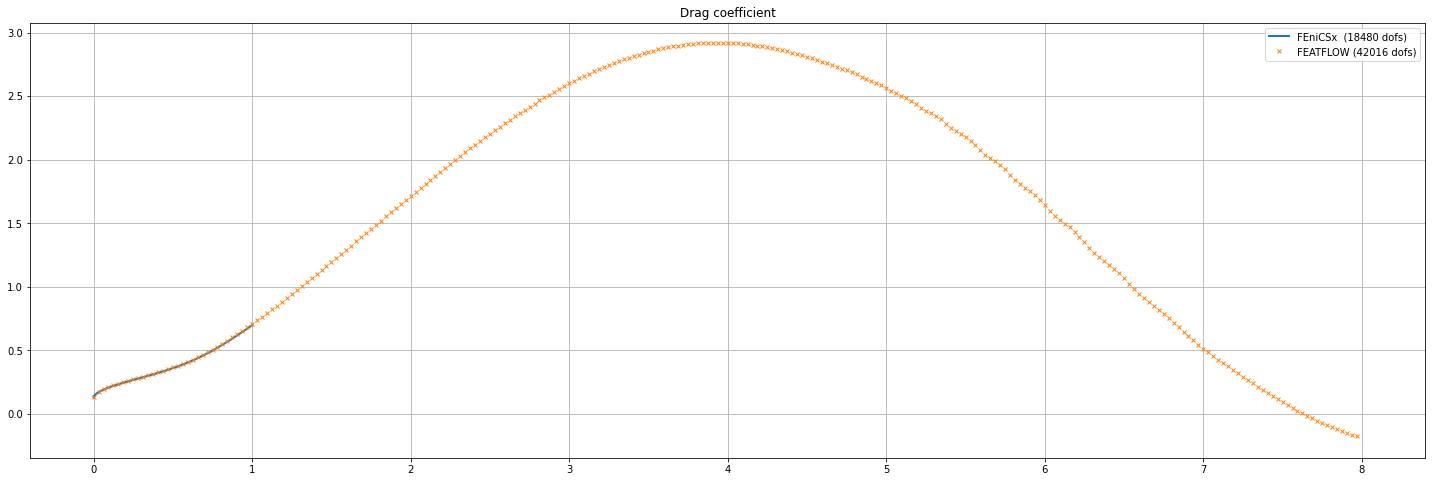

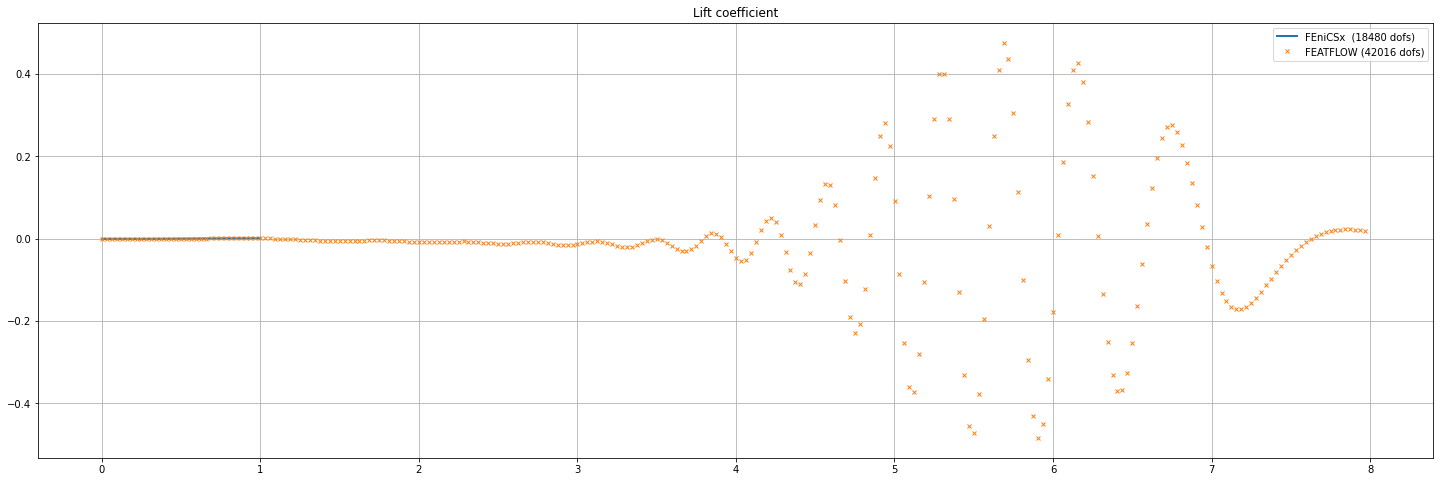

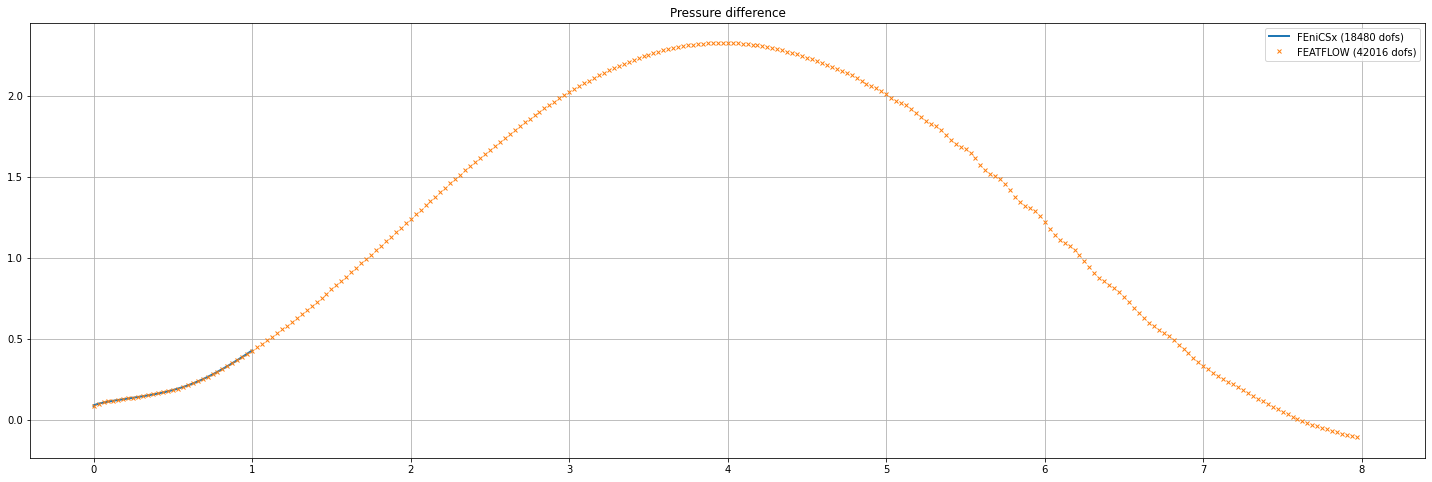

In [18]:
if rank == 0:
    num_velocity_dofs = V.dofmap.index_map_bs * V.dofmap.index_map.size_global
    num_pressure_dofs = Q.dofmap.index_map_bs * V.dofmap.index_map.size_global
    
    turek = np.loadtxt("bdforces_lv4")
    turek_p = np.loadtxt("pointvalues_lv4")
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(25,8))
    l1 = plt.plot(t_u, C_D, label=r"FEniCSx  ({0:d} dofs)".format(num_velocity_dofs+num_pressure_dofs),linewidth=2)
    l2 = plt.plot(turek[1:,1], turek[1:,3], marker="x", markevery=50, 
                linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
    plt.title("Drag coefficient")
    plt.grid()
    plt.legend()
    plt.savefig("drag_comparison.png")

    fig = plt.figure(figsize=(25,8))
    l1 = plt.plot(t_u, C_L, label=r"FEniCSx  ({0:d} dofs)".format(
        num_velocity_dofs+num_pressure_dofs),linewidth=2)
    l2 = plt.plot(turek[1:,1], turek[1:,4], marker="x", markevery=50, 
                linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
    plt.title("Lift coefficient")
    plt.grid()
    plt.legend()
    plt.savefig("lift_comparison.png")

    fig = plt.figure(figsize=(25,8))
    l1 = plt.plot(t_p, p_diff, label=r"FEniCSx ({0:d} dofs)".format(num_velocity_dofs+num_pressure_dofs),linewidth=2)
    l2 = plt.plot(turek[1:,1], turek_p[1:,6]-turek_p[1:,-1], marker="x", markevery=50, 
                linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
    plt.title("Pressure difference")
    plt.grid()
    plt.legend()
    plt.savefig("pressure_comparison.png")


We observe an offset in amplitude. This is due to the reduced number of degrees of freedom compared to FEATFLOW. If we change the parameters `res_min` to `r/5`, and `res_max` to `r`, we can obtain a result closer to the FEATFLOW benchmark. It is recommended to convert the notebook to a python-script using [nbconvert](https://nbconvert.readthedocs.io/en/latest/) and using `mpirun -n 4 python3 ns_code2.py` to run the python program distributed over 4 processors. 